# Importing packages

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import math
from collections import Counter
from dataclasses import dataclass
import random

# Generating data for classification

In [105]:
x1 = np.random.normal(loc=(0,1), scale=(0.5, 0.5), size=(100,2))
y1 = np.zeros(100)
x2 = np.random.normal(loc=(0,-1), scale=(0.5, 0.5), size=(100,2))
y2 = np.ones(100)

X = np.concat([x1, x2], axis = 0)
y = np.concat([y1, y2])

Text(0.5, 1.0, 'scatter plot of the two categories')

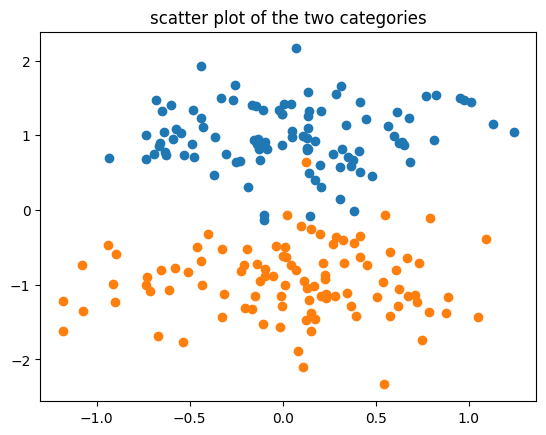

In [106]:
for label in np.unique(y):
    mask = y == label
    plt.scatter(X[mask,0], X[mask,1], label=label)
plt.title("scatter plot of the two categories")

# Bulding a tree class

In [60]:
@dataclass
class Node:
    split: Tuple[Optional[int], Optional[float]] = (None, None)
    left: Optional["Node"] = None
    right: Optional["Node"] = None
    inference: Optional[float] = None
    

class Tree:
    def __init__(self, task: str , feature_proportion :float = 1):
        self.root = Node()
        assert task in ["classification", "regression"], f"Task {task} is not supported, please chose either classification or regression"
        self.task = task
        self.p= feature_proportion

    def fit (self,  X: list, y: list) -> None:
        """
        fits the tree to the data
        """
        def recursive_fit(node, X:list, y:list) -> None:
            assert isinstance(X, list) and all([isinstance(x, list) for x in X]), f"in recursive_fit: X = {X}"
            #assert isinstance(y, list) and all([isinstance(y_i, (float,int))  for y_i in y]), f"in recursive_fit: y = {y}"
            # if len(X) <= 1:
            #     node.inference = y[0]
            #     return
            split_dim, split_value = self.find_split(X, y)
            if split_dim is None:
                node.inference = y[0]
                return
            node.split = (split_dim, split_value)
            left_x = []
            left_y = []
            right_x = []
            right_y = []
            for i, x_i in enumerate(X):
                if x_i[split_dim] <= split_value:
                    left_x.append(x_i)
                    left_y.append(y[i])
                else:
                    right_x.append(x_i)
                    right_y.append(y[i])
            node.left = Node()
            node.right = Node()
            assert len(left_x) > 0 and len(right_x) > 0, f"{right_x}, {left_x}, {X}, {y}"   
            recursive_fit(node.left, left_x, left_y)
            recursive_fit(node.right, right_x, right_y)

        recursive_fit(self.root, X, y)

    def find_split(self, X: list[list[float]], y: list[float]) -> tuple[int, float]:
        """
        finds the best split (dimension + thershold)
        """
        assert isinstance(X, list) and isinstance(X[0], list), X
        #assert isinstance(y, list) and all([isinstance(y_i, (float,int))  for y_i in y]), f"in find_split: {y}"
        dim = len(X[0])
        max_gain = -float('inf')
        split_dim, split_value = None, None
        features =  random.sample(list(range(dim)), int(dim * self.p))
        #print(features, dim)
        for dim_i in features:
            for i, x in enumerate(X):
                gain_i = self.split_gain(X, y, dim_i, x[dim_i])
                if gain_i > max_gain:
                    max_gain = gain_i
                    split_dim, split_value = dim_i, x[dim_i]
        
        return split_dim, split_value
    
    def split_gain(self, X: list[list[float]], y: list[float], dim_i: int, split_value: float) -> float:
        """
        Computes the split gain for a certain dimension and a certain thershold
        """
        assert type(X) == list and type(X[0]) == list, X
        assert type(dim_i) == int, dim_i
        assert isinstance(split_value, (float, int)), split_value
        #assert isinstance(y, list) and all([isinstance(y_i, (float,int))  for y_i in y]), y

        left_y = []
        right_y = []
        for i, x in enumerate(X):
            if x[dim_i] <= split_value:
                left_y.append(y[i])
            else:
                right_y.append(y[i])
        if len(left_y) == 0 or len(right_y) == 0:
            return -float("inf")
        return self.purity(left_y, right_y)
    
    def compute_entropy(self,y):
        counts = Counter(y)
        total_counts = sum(counts.values())
        return sum([(-c/total_counts) * math.log10(c) for c in counts.values()])
    
    def compute_gini(self, y):
        counts = Counter(y)
        total_counts = sum(counts.values())
        return 1 - sum([(c/total_counts) ** 2 for c in counts.values()])
        
    

    def purity(self, left_y: list[float], right_y: list[float]) -> float:
        """
        Computes the purity gain for a certain split of the labels y into two subgroups
        """
        len_left = len(left_y)
        len_right = len(right_y)
        if self.task == "regression":
            mean_left_y = sum(left_y) / len_left
            mse_left_y = (1/len_left) * sum([(y -  mean_left_y)**2 for y in left_y])
            mean_right_y = sum(right_y) / len_right
            mse_right_y = (1/len_right) * sum([(y - mean_right_y)**2 for y in right_y])
            return - (mse_left_y  * len_left + mse_right_y * len_right) / (len_left + len_right)
        
        if self.task == "classification":
            # n_classes =  max(left_y + right_y) + 1
            # counts_left = [0] * n_classes
            # counts_right = [0] * n_classes
            # for y in left_y:
            #     counts_left[y] += 1
            # for y in right_y:
            #     counts_right[y] += 1
            # print(counts_right)
            entropy_left = self.compute_entropy(left_y)
            entropy_right = self.compute_entropy(right_y)

            return - (entropy_left  * len_left + entropy_right * len_right) / (len_left + len_right)
    
    def predict(self, X: list[list[float]]):
        def rec_go_down_tree(node, x):
            #print(node, "\n")
            split_dim, thershold = node.split
            if split_dim is None: # if it is leaf, so has no further splits
                return node.inference
            if x[split_dim] <= thershold:
                return rec_go_down_tree(node.left, x)
            else:
                return rec_go_down_tree(node.right, x)

        y = []
        for x in X:
            leaf_value = rec_go_down_tree(self.root, x)
            y.append(leaf_value)
        return y



            


X = [[-3,3], [-2,0], [-1,0], [0,7], [1,1]]
y = [-3, 4, 5, 1, 0]

tree = Tree("regression", feature_proportion = 0.5)
tree.fit(X,y)
tree.predict(X)


[-3, 4, 4, 1, 0]

In [ ]:
# 1) Regression: y ≈ x0
X = [[0.0],[1.0],[2.0],[3.0],[4.0]]
y = [0.1, 0.9, 2.1, 3.0, 3.9]
tr = Tree("regression"); tr.fit(X,y)
print("reg preds:", tr.predict(X))


# 2) Classification
X = [[0.0],[1.0],[2.0],[3.0],[4.0]]
y = ["cat", "cat", "cat", "dog", "fish"]
tr = Tree("classification"); tr.fit(X,y)
print("reg preds:", tr.predict(X))

reg preds: [0.1, 0.9, 2.1, 3.0, 3.9]


# Random Forest

In [72]:
class random_forest:
    def __init__(self, task:str, n_trees:int = 100, proportion: float = 0.7):
        self.list_trees = [Tree(task = task, feature_proportion= proportion) for i in range(n_trees)]
        self.task = task

    def fit(self, X, y):
        for i in range(len(self.list_trees)):
            self.list_trees[i].fit(X, y)
    
    def predict(self, X):
        L_result = []
        for tree_i in self.list_trees:
            L_result.append( tree_i.predict(X) )

        print(L_result)
        ziped_L_result = (zip(*L_result))
        
        if self.task == "regression":
            return [sum(pred) / len(pred) for pred in ziped_L_result]
        
        if self.task == "classification":
            return [Counter(pred).most_common(1)[0][0] for pred in ziped_L_result]
        

rf = random_forest("regression")
X = [[0,0,1,3], [2,3,4,4], [5,5,2,-5], [6,7,0,7], [2,-1,-1,0]]
y = [0.1, 0.9, 2.1, 3.0, 3.9]
rf.fit(X,y)
print("reg preds:", rf.predict(X))

[[0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], [0.1, 0.9, 2.1, 3.0, 3.9], 

In [103]:

# 2) Classification

rf = random_forest("classification", proportion = 0.3)
X = [[0,0,1,3], [2,3,4,4], [5,5,2,-5], [6,7,0,7], [2,-1,-1,0]]
y = ["cat", "cat", "cat", "dog", "fish"]
rf.fit(X,y)
print("reg preds:", rf.predict(X))

[['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'cat', 'cat', 'dog', 'fish'], ['cat', 'ca

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

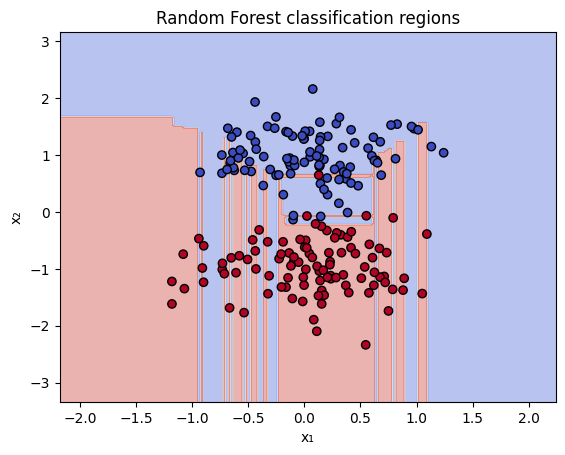

In [107]:
# --- fit your forest ---
rf = random_forest(task="classification", n_trees=20, proportion=0.7)
rf.fit(X.tolist(), y.tolist())

# --- plot decision boundary ---
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 200),
    np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array(rf.predict(grid.tolist())).reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k")
plt.title("Random Forest classification regions")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()

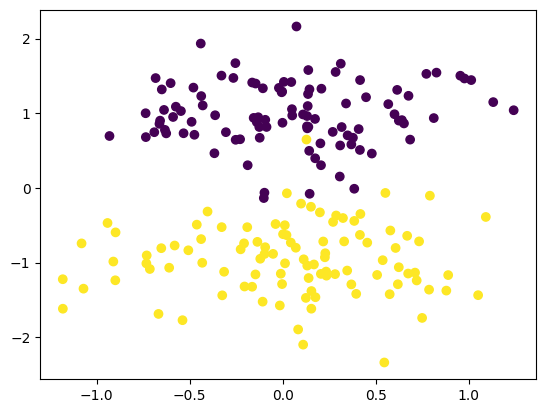

In [109]:
plt.scatter(X[:, 0], X[:, 1], c=y)